<a href="https://colab.research.google.com/github/matthewshawnkehoe/Data-Analysis/blob/main/chapter11_part03_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it contains runnable code blocks, text, figures, section titles, and a bunch of edits by Matthew Kehoe.

This notebook was generated for TensorFlow 2.6.

## The Transformer architecture

Starting in 2017, a new model architecture started overtaking recurrent neural networks across most natural language processing tasks: the Transformer.

Transformers were introduced in the seminal paper [Attention is all you need](https://arxiv.org/abs/1706.03762) by Vaswani et al. The gist of the paper is right there in the title: as it turned out, a simple mechanism called <font color='blue'>neural attention</font> could be used to build powerful sequence models that didn't feature any recurrent layers or convolution layers.

This finding unleashed nothing short of a revolution in natural language processing—and beyond. Neural attention has fast become one of the most influential ideas in deep learning. In this section, you'll get an in-depth explanation of how it works and why it has proven so effective for sequence data. We'll then leverage self-attention to create a <font color='blue'>Transformer encoder</font>, one of the basic components of the Transformer architecture, and we'll apply it to the <font color='blue'>IMDB movie review</font> classification task.

### Understanding self-attention

As you're going through this book, you may be skimming some parts and attentively reading others, depending on what your goals or interests are. What if your models did the same? It's a simple yet powerful idea: <font color='blue'>not all input information</font> seen by a model is <font color='blue'>equally important</font> to the task at hand, so models should <font color='blue'>pay more attention</font> to some features and <font color='blue'>pay less attention</font> to other features.

Does that sound familiar? You've already encountered a similar concept twice in
this book:

- <font color='blue'>Max pooling</font> in convnets looks at a pool of features in a spatial region and selects just one feature to keep. That's an "all or nothing" form of attention:
keep the most important feature and discard the rest.
- <font color='blue'>TF-IDF normalization</font> assigns importance scores to tokens based on how much information different tokens are likely to carry. Important tokens get boosted while irrelevant tokens get faded out. That's a continuous form of attention.

There are many different forms of attention you could imagine, but they all start by computing <font color='blue'>importance scores</font> for a set of <font color='blue'>features</font>, with higher scores for more relevant features and lower scores for less relevant ones (see figure below). How these scores should be computed, and what you should do with them, will vary from approach to approach.

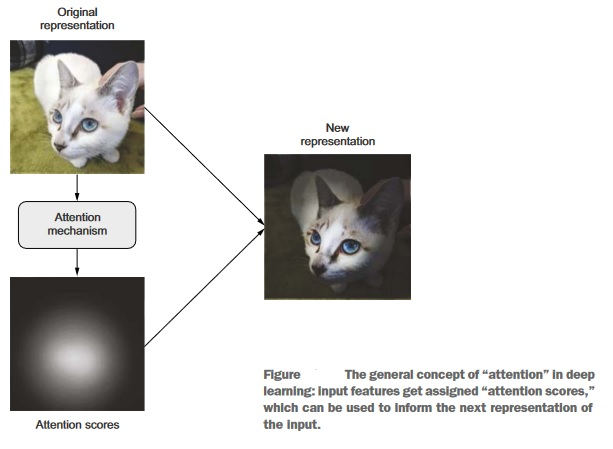

Crucially, this kind of <font color='blue'>attention mechanism</font> can be used for more than just highlighting or erasing certain features. It can be used to <font color='blue'>make features context-aware</font>. You've just learned about <font color='blue'>word embeddings</font>—vector spaces that capture the “shape” of the semantic relationships between different words. In an embedding space, a <font color='blue'>single</font> word has a <font color='blue'>fixed position</font>—a fixed set of relationships with every other word in the space. But that's not quite how language works: the <font color='blue'>meaning</font> of a <font color='blue'>word</font> is usually <font color='blue'>context specific</font>. When you mark the date, you're not talking about the same “date” as when you go on a date, nor is it the kind of date you'd buy at the market. When you say, “<font color='blue'>I'll see you soon</font>,” the meaning of the word <font color='blue'>see</font> is subtly different from the <font color='blue'>see</font> in “<font color='blue'>I'll see this project to its end</font>” or “<font color='blue'>I see what you mean</font>.” And, of course, the meaning of pronouns like “he,” “it,” “in,” etc., is entirely sentence specific and can even change multiple times within a single sentence.

Clearly, a smart <font color='blue'>embedding space</font> would provide a different <font color='blue'>vector representation</font>
for a <font color='blue'>word</font> depending on the <font color='blue'>other words surrounding it</font>. That's where self-attention comes in. The purpose of <font color='blue'>self-attention</font> is to <font color='blue'>modulate</font> the <font color='blue'>representation</font> of a <font color='blue'>token</font> by using the representations of <font color='blue'>related tokens</font> in the sequence. This produces context aware token representations. Consider an example sentence: "The train left the station on time." Now, consider one word in the sentence: station. What kind of station are we talking about? Could it be a radio station? Maybe the International Space Station? Let's figure it out algorithmically via self-attention (see figure below).

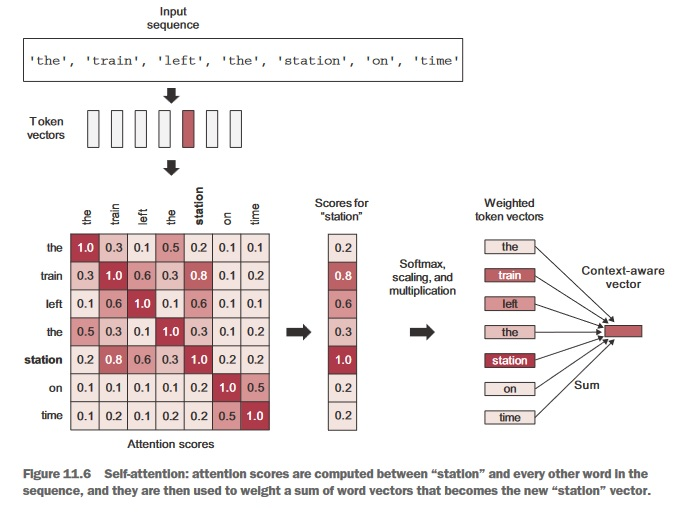

<font color='blue'>Step 1</font> is to compute relevancy scores between the vector for <font color='blue'>station</font> and every other word in the sentence. These are our <font color='blue'>attention scores</font>. We're simply going to use the <font color='blue'>dot product</font> between two word vectors as a measure of the strength of their relationship. It's a very computationally efficient distance function, and it was already the standard way to relate two word embeddings to each other long before Transformers. In practice, these scores will also go through a scaling function and a softmax, but for
now, that's just an implementation detail.

<font color='blue'>Step 2</font> is to compute the <font color='blue'>sum</font> of all word vectors in the sentence, weighted by our relevancy scores. Words closely related to “station” will contribute more to the sum (including the word “station” itself), while irrelevant words will contribute almost nothing. The <font color='blue'>resulting vector</font> is our new representation for <font color='blue'>station</font>: a representation that incorporates the surrounding context. In particular, it includes part of the “train” vector, clarifying that it is, in fact, a “train station.”

You'd repeat this process for every word in the sentence, producing a new
sequence of vectors encoding the sentence. Let's see it in NumPy-like pseudocode:

In [ ]:
# Psuedocode

def self_attention(input_sequence):
    output = np.zeros(shape=input_sequence.shape)
    for i, pivot_vector in enumerate(input_sequence):                           # Iterate over each token in the input sequence
        scores = np.zeros(shape=(len(input_sequence),))
        for j, vector in enumerate(input_sequence):
            scores[j] = np.dot(pivot_vector, vector.T)                          # Compute the dot product (attention score) between the token and every other token
        scores /= np.sqrt(input_sequence.shape[1])                              # Scale by a normalization factor
        scores = softmax(scores)                                                # and apply a softmax
        new_pivot_representation = np.zeros(shape=pivot_vector.shape)
        for j, vector in enumerate(input_sequence):
            new_pivot_representation += vector * scores[j]                      # Take the sum of all tokens weighted by the attention scores
        output[i] = new_pivot_representation                                    # That sum is our output
    return output

Of course, in practice you'd use a <font color='blue'>vectorized</font> implementation. Keras has a built-in layer to handle it: the `MultiHeadAttention` layer. Here's how you would use it:

In [ ]:
# Psuedocode

num_heads = 4
embed_dim = 256
mha_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
outputs = mha_layer(inputs, inputs, inputs)

NameError: ignored

Reading this, you're probably wondering
- Why are we passing the inputs to the layer <font color='blue'>three</font> times? That seems redundant.
- What are these <font color='blue'>multiple heads</font> we're referring to? That sounds intimidating—
do they also grow back if you cut them?

Both of these questions have straightforward answers. Let's take a look.

#### Generalized self-attention: the query-key-value model

So far, we have only considered <font color='blue'>one</font> input sequence. However, the Transformer architecture was originally developed for machine translation, where you have to deal with <font color='blue'>two</font> input sequences: the <font color='blue'>source</font> sequence you're currently translating (such as “How's the weather today?”), and the <font color='blue'>target</font> sequence you're converting it to (such as “¿Qué tiempo hace hoy?”). A <font color='blue'>Transformer</font> is a <font color='blue'>sequence-to-sequence</font> model: it was designed to <font color='blue'>convert one sequence into another</font>. You'll learn about sequence-to-sequence models in depth later in this chapter.

Now let's take a step back. The self-attention mechanism as we've introduced it
performs the following, schematically:

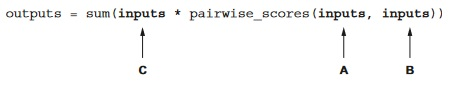

This means “for each token in inputs (A), compute how much the <font color='blue'>token</font> is <font color='blue'>related</font> to <font color='blue'>every token in inputs (B)</font>, and use these scores to <font color='blue'>weight</font> a <font color='blue'>sum of tokens</font> from inputs (C).” Crucially, there's nothing that requires A, B, and C to refer to the same input sequence. In the general case, you could be doing this with three different sequences. We'll call them “query,” “keys,” and “values.” The operation becomes “for each element in the query, compute how much the element is related to every key, and use these scores to weight a sum of values”:

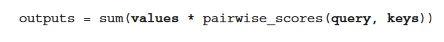

This terminology comes from <font color='blue'>search engines and recommender systems</font> (see figure
below). Imagine that you're typing up a query to retrieve a photo from your collection— <font color='blue'>dogs on the beach</font>. Internally, each of your pictures in the database is described by a set of keywords—“cat,” “dog,” “party,” etc. We'll call those <font color='blue'>keys</font>. The search engine will start by <font color='blue'>comparing</font> your <font color='blue'>query</font> to the keys in the database. “Dog” yields a match of 1, and “cat” yields a match of 0. It will then <font color='blue'>rank</font> those keys by <font color='blue'>strength</font> of <font color='blue'>match—relevance</font> and it will return the pictures associated with the top N matches, in order of relevance.

Conceptually, this is what Transformer-style attention is doing. You've got a <font color='blue'>reference sequence</font> that describes something you're looking for: the <font color='blue'>query</font>. You've got a <font color='blue'>body of knowledge</font> that you're trying to extract information from: the <font color='blue'>values</font>. Each value is assigned a key that describes the value in a format that can be readily compared to a query. You simply match the query to the keys. Then you return a <font color='blue'>weighted sum</font> of values.

In practice, the keys and the values are often the same sequence. In machine translation, for instance, the query would be the target sequence, and the source sequence would play the roles of both keys and values: for each element of the target (like “tiempo”), you want to go back to the source (“How's the weather today?”) and identify the different bits that are related to it (“tiempo” and “weather” should have a strong match). And naturally, if you're just doing sequence classification, then query, keys, and values are all the same: you're comparing a sequence to itself, to enrich each token with context from the whole sequence. That explains why we needed to pass inputs three times to our MultiHeadAttention layer. But why “multi-head” attention?

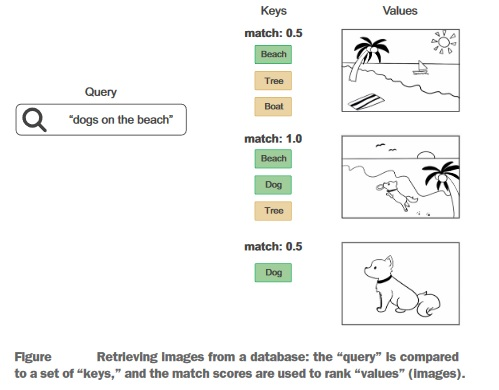

### Multi-head attention

<font color='blue'>Multi-head attention</font> is an extra <font color='blue'>tweak</font> to the <font color='blue'>self-attention mechanism</font>, introduced in “Attention is all you need.” The “multi-head” moniker refers to the fact that the output space of the self-attention layer gets factored into a set of <font color='blue'>independent subspaces, learned separately</font>: the initial query, key, and value are sent through three <font color='blue'>independent sets</font> of dense projections, resulting in three separate vectors. Each vector is processed via neural attention, and the different outputs are concatenated back together into a single output sequence. Each such subspace is called a <font color='blue'>head</font>. The full picture is shown in the figure below.

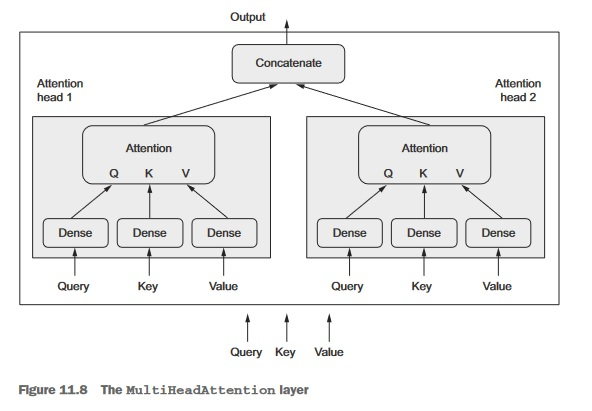

The presence of the <font color='blue'>learnable dense projections</font> enables the <font color='blue'>layer</font> to actually <font color='blue'>learn something</font>, as opposed to being a purely stateless transformation that would require additional layers before or after it to be useful. In addition, having <font color='blue'>independent heads</font> helps the layer <font color='blue'>learn different groups of features</font> for each token, where features within one group are correlated with each other but are mostly independent from features in a different group.

This is similar in principle to what makes <font color='blue'>depthwise separable convolutions</font> work: in a depthwise separable convolution, the <font color='blue'>output space</font> of the <font color='blue'>convolution</font> is factored into <font color='blue'>many subspaces</font> (one per input channel) that get learned independently. The “Attention is all you need” paper was written at a time when the idea of factoring feature spaces into independent subspaces had been shown to provide great benefits for computer vision models—both in the case of depthwise separable convolutions, and in the case of a closely related approach, grouped convolutions. Multi-head attention is simply the application of the same idea to self-attention.

### The Transformer encoder

If adding extra dense projections is so useful, why don't we also apply <font color='blue'>one or two</font> to the <font color='blue'>output</font> of the <font color='blue'>attention mechanism</font>? Actually, that's a great idea—let's do that. And our model is starting to do a lot, so we might want to add <font color='blue'>residual connections</font> to make sure we don't destroy any valuable information along the way—you learned in chapter 9 that they're a <font color='blue'>must</font> for any sufficiently deep architecture. And there's another thing you learned in chapter 9: <font color='blue'>normalization layers</font> are supposed to help gradients flow better during backpropagation. Let's add those too.

That's roughly the thought process that I imagine unfolded in the minds of the
inventors of the Transformer architecture at the time. Factoring <font color='blue'>outputs</font> into <font color='blue'>multiple independent spaces</font>, adding residual connections, adding normalization layers—all of these are standard architecture patterns that one would be wise to leverage in any complex model. Together, these bells and whistles form the Transformer encoder—one of two critical parts that make up the Transformer architecture (see figure below).

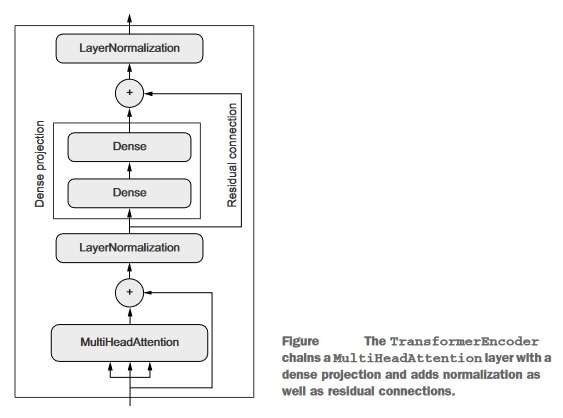

The <font color='blue'>original</font> Transformer architecture consists of two parts: a <font color='blue'>Transformer encoder</font> that processes the source sequence, and a <font color='blue'>Transformer decoder</font> that uses the source sequence to generate a translated version. You'll learn about about the decoder part in a minute.

Crucially, the <font color='blue'>encoder</font> part can be used for <font color='blue'>text classification</font>—it's a very generic module that ingests a sequence and learns to turn it into a more useful representation. Let's implement a Transformer encoder and try it on the movie review sentiment classification task.

**Getting the data**

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  9019k      0  0:00:09  0:00:09 --:--:-- 16.4M


This gives us a directory named <font color='blue'>aclImdb</font>, with the following structure:
```
aclImdb/
...train/
......pos/
......neg/
...test/
......pos/
......neg/
...val/
......pos/
......neg/
```

**Preparing the data**

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**Vectorizing the data**

In [ ]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

**Transformer encoder implemented as a subclassed `Layer`**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim                                              # Size of the input token vectors
        self.dense_dim = dense_dim                                              # Size of the inner dense layer
        self.num_heads = num_heads                                              # Number of attention heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):                                          # Computation goes in call().
        if mask is not None:
            mask = mask[:, tf.newaxis, :]                                       # The mask that will be generated by the Embedding layer will be 2D, but
                                                                                # the attention layer expects to be 3D or 4D, so we expand its rank.
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):                                                       # Implement serialization so we can save the model.
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

**Remark - Saving custom layers:**
When you write <font color='blue'>custom</font> layers, make sure to implement the `get_config` method: this enables the layer to be reinstantiated from its config dictionary, which is useful during model saving and loading. The method should return a Python dictionary that contains the values of the constructor arguments used to create the layer.

All Keras layers can be serialized and deserialized as follows:

In [ ]:
config = layer.get_config()
new_layer = layer.__class__.from_config(config)                                 # The config does not contain weight values, so all weights in the
                                                                                # layer get initialized from scratch.

NameError: ignored

For instance:

In [ ]:
layer = PositionalEmbedding(sequence_length, input_dim, output_dim)
config = layer.get_config()
new_layer = PositionalEmbedding.from_config(config)

NameError: ignored

When saving a model that contains custom layers, the savefile will contain these config dictionary. When loading the model from the file, you should provide the custom layer classes to the loading process, so that it can make sense of the config objects:

In [ ]:
model = keras.models.load_model(filename,
                                custom_objects={"PositionalEmbedding": PositionalEmbedding}
                                )

You'll note that the <font color='blue'>normalization layers</font> we're using here aren't <font color='blue'>BatchNormalization</font> layers like those we've used before in image models. That's because <font color='blue'>BatchNormalization</font> doesn't work well for sequence data. Instead, we're using the <font color='blue'>LayerNormalization</font> layer, which normalizes each sequence independently from other sequences in the batch. Like this, in NumPy-like pseudocode:

In [ ]:
def layer_normalization(batch_of_sequences):                                    # Input shape: (batch_size, sequence_length, embedding_dim)
  mean = np.mean(batch_of_sequences, keepdims=True, axis=-1)                    # To compute mean and variance, we only pool data over the last axis (axis -1).
  variance = np.var(batch_of_sequences, keepdims=True, axis=-1)
  return (batch_of_sequences - mean) / variance

Compare to `BatchNormalization` (during training):

In [ ]:
def batch_normalization(batch_of_images):                                       # Input shape: (batch_size, height, width, channels)
  mean = np.mean(batch_of_images, keepdims=True, axis=(0, 1, 2))                # Pool data over the batch axis (axis 0), which creates interactions
  variance = np.var(batch_of_images, keepdims=True, axis=(0, 1, 2))             # between samples in a batch.
  return (batch_of_images - mean) / variance

While <font color='blue'>BatchNormalization</font> collects information from many samples to obtain accurate statistics for the feature means and variances, <font color='blue'>LayerNormalization</font> pools data within each sequence separately, which is more appropriate for sequence data.

Now that we've implemented our <font color='blue'>TransformerEncoder</font>, we can use it to assemble a
text-classification model similar to the GRU-based one you've seen previously.

**Using the Transformer encoder for text classification**

In [ ]:
vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)                                              # Since TransformerEncoder returns full sequences, we need to reduce each
                                                                                # sequence to a single vector for classification via a global pooling layer.

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 transformer_encoder (Transf  (None, None, 256)        543776    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257   

**Remark:** For Global Max Pooling, see [here](https://github.com/christianversloot/machine-learning-articles/blob/main/what-are-max-pooling-average-pooling-global-max-pooling-and-global-average-pooling.md).

**Training and evaluating the Transformer encoder based model**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})                  # Provide the custom TransformerEncoder class to the model-loading process.
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/20
625/625 [==============================] - 104s 155ms/step - loss: 0.4977 - accuracy: 0.7656 - val_loss: 0.4557 - val_accuracy: 0.7736
Epoch 2/20
625/625 [==============================] - 70s 113ms/step - loss: 0.3376 - accuracy: 0.8550 - val_loss: 0.3442 - val_accuracy: 0.8500
Epoch 3/20
625/625 [==============================] - 54s 86ms/step - loss: 0.3048 - accuracy: 0.8727 - val_loss: 0.3075 - val_accuracy: 0.8680
Epoch 4/20
625/625 [==============================] - 50s 80ms/step - loss: 0.2712 - accuracy: 0.8870 - val_loss: 0.2960 - val_accuracy: 0.8732
Epoch 5/20
625/625 [==============================] - 50s 80ms/step - loss: 0.2415 - accuracy: 0.9006 - val_loss: 0.2837 - val_accuracy: 0.8826
Epoch 6/20
625/625 [==============================] - 46s 74ms/step - loss: 0.2106 - accuracy: 0.9157 - val_loss: 0.2988 - val_accuracy: 0.8770
Epoch 7/20
625/625 [==============================] - 47s 76ms/step - loss: 0.1856 - accuracy: 0.9279 - val_loss: 0.3174 - val_accura

Let's train it. It gets to <font color='blue'>87.7%</font> test accuracy—slightly worse than the GRU model. At this point, you should start to feel a bit uneasy. Something's off here. Can you tell what it is?

This section is ostensibly about <font color='blue'>sequence models</font>. We started off by highlighting the importance of word order. We said that Transformer was a sequence-processing architecture, originally developed for machine translation. And yet . . . the Transformer encoder you just saw in action <font color='blue'>wasn't a sequence model</font> at all. Did you notice? It's composed of <font color='blue'>dense layers</font> that process sequence <font color='blue'>tokens independently</font> from each other, and an attention layer that looks at the tokens as a set. You could change the order of the tokens in a sequence, and you'd get the exact same pairwise attention scores and the exact same context-aware representations. If you were to completely scramble the words in every movie review, the model wouldn't notice, and you'd still get the exact same accuracy. <font color='blue'>Self-attention</font> is a <font color='blue'>set-processing</font> mechanism, focused on the <font color='blue'>relationships</font> between <font color='blue'>pairs of sequence elements</font> (see figure below)—it's blind to whether these elements occur at the beginning, at the end, or in the middle of a sequence. So why do we say that Transformer is a sequence model? And how could it possibly be good for machine translation if it doesn't look
at word order?

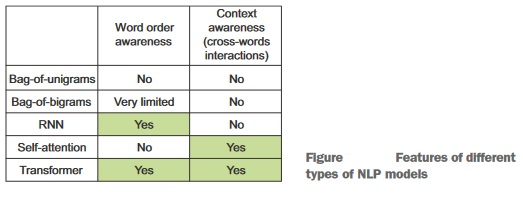

We hinted at the solution earlier in the chapter: we mentioned in passing that <font color='blue'>Transformer</font> was a <font color='blue'>hybrid approach</font> that is technically <font color='blue'>order-agnostic</font>, but that manually injects order information in the representations it processes. This is the missing ingredient! It's called <font color='blue'>positional encoding</font>. Let's take a look.

#### Using positional encoding to re-inject order information

The idea behind <font color='blue'>positional encoding</font> is straightforward: to give the model <font color='blue'>access</font> to <font color='blue'>word-order information</font>, we're going to add the <font color='blue'>word's position</font> in the sentence to each word embedding. Our input word embeddings will have <font color='blue'>two</font> components: the usual <font color='blue'>word vector</font>, which represents the word independently of any specific context, and a <font color='blue'>position vector</font>, which represents the position of the word in the current sentence. Hopefully, the model will then figure out how to best leverage this additional information.

The simplest scheme you could come up with would be to <font color='blue'>concatenate</font> the word's <font color='blue'>position</font> to its <font color='blue'>embedding vector</font>. You'd add a “position” axis to the vector and fill it with 0 for the first word in the sequence, 1 for the second, and so on.

That may not be ideal, however, because the positions can potentially be very large integers, which will disrupt the range of values in the embedding vector. As you know, neural networks don't like very large input values, or discrete input distributions.

The original <font color='blue'>Attention is all you need</font> paper used an interesting trick to encode word positions: it added to the word embeddings a vector containing values in the range `[-1, 1]` that varied cyclically depending on the position (it used cosine functions to achieve this). This trick offers a way to uniquely characterize any integer in a large range via a vector of small values. It's clever, but it's not what we're going to use in our case. We'll do something simpler and more effective: we'll learn position-embedding vectors the same way we learn to embed word indices. We'll then proceed to add our position embeddings to the corresponding word embeddings, to obtain a position-aware word embedding. This technique is called “positional embedding.” Let's implement it.

**Implementing positional embedding as a subclassed layer**

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):       # A downside of position embeddings is that the sequence length needs to be known in advance.
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(                               # Prepare an Embedding layer for the token indices.
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(                            # And another one for the token positions.
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions                             # Add both embedding vectors together.

    def compute_mask(self, inputs, mask=None):                                  # Like the Embedding layer, this layer should be able to generate a mask so we can
        return tf.math.not_equal(inputs, 0)                                     # ignore padding 0s in the inputs. The compute_mask method will called automatically
                                                                                # by the framework, and the mask will get propagated to the next layer.

    def get_config(self):                                                       # Implement serialization so we can save the model.
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

You would use this `PositionEmbedding` layer just like a regular `Embedding` layer. Let's see it in action!

#### Putting it all together: A text-classification Transformer

All you have to do to start taking word order into account is swap the old `Embedding` layer with our position-aware version.

**Combining the Transformer encoder with positional embedding**

In [ ]:
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)         # Swapped Embedding with PositionalEmbedding
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        5273600   
 ionalEmbedding)                                                 
                                                                 
 transformer_encoder_1 (Tran  (None, None, 256)        543776    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                           

We get to <font color='blue'>88.1%</font> test accuracy, a solid improvement that clearly demonstrates the
value of <font color='blue'>word order information</font> for <font color='blue'>text classification</font>. This is our best sequence model so far! However, it's still one notch below the bag-of-words approach.

### When to use sequence models over bag-of-words models?

You may sometimes hear that bag-of-words methods are outdated, and that Transformer based sequence models are the way to go, no matter what task or dataset you're looking at. This is definitely not the case: a small stack of `Dense` layers on top of a bag-of-bigrams remains a perfectly valid and relevant approach in many cases. In fact, among the various techniques that we've tried on the IMDB dataset throughout this chapter, the <font color='blue'>best performing</font> so far was the <font color='blue'>bag-of-bigrams</font>!

So, when should you prefer one approach over the other?

In 2017, our team ran a systematic analysis of the performance of various text classification techniques across many different types of text datasets, and we discovered a remarkable and surprising rule of thumb for deciding whether to go with a bag-of-words model or a sequence model (http://mng.bz/AOzK)— a golden constant of sorts.

It turns out that when approaching a new text-classification task, you should pay close attention to the <font color='blue'>ratio</font> between the <font color='blue'>number of samples</font> in your training data and the <font color='blue'>mean number of words per sample</font> (see figure below). If that ratio is <font color='blue'>small</font>—less than 1,500 words—then the <font color='blue'>bag-of-bigrams</font> model will perform better (and as a bonus, it will be much faster to train and to iterate on too). If that ratio is <font color='blue'>higher than 1,500 words</font>, then you should go with a <font color='blue'>sequence model</font>. In other words, sequence models work best when lots of training data is available and when each sample is relatively short.

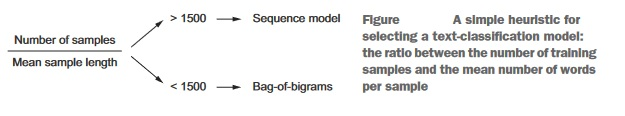

So if you're classifying 1,000-word long documents, and you have 100,000 of them (a <font color='blue'>ratio of 100</font>), you should go with a <font color='blue'>bigram model</font>. If you're classifying tweets that are 40 words long on average, and you have 50,000 of them (a <font color='blue'>ratio of 1,250</font>), you should also go with a <font color='blue'>bigram model</font>. But if you increase your dataset size to 500,000 tweets (a <font color='blue'>ratio of 12,500</font>), go with a <font color='blue'>Transformer encoder</font>. What about the IMDB movie review classification task? We had <font color='blue'>20,000 training samples</font> and an average word count of <font color='blue'>233</font>, so our rule of thumb points toward a <font color='blue'>bigram model</font>, which confirms what we found in practice.

This intuitively makes sense: the input of a <font color='blue'>sequence model</font> represents a <font color='blue'>richer and more complex space</font>, and thus it takes more data to map out that space; meanwhile, a <font color='blue'>plain set of terms</font> is a space so simple that you can train a <font color='blue'>logistic regression</font> on top using just a few hundreds or thousands of samples. In addition, the <font color='blue'>shorter a sample</font> is, the <font color='blue'>less the model</font> can <font color='blue'>afford to discard</font> any of the <font color='blue'>information</font> it contains—in particular, word order becomes more important, and discarding it can create ambiguity. The sentences “this movie is the bomb” and “this movie was a bomb” have very close unigram representations, which could confuse a bag-of-words model, but a sequence model could tell which one is negative and which one is positive. With a longer sample, word statistics would become more reliable and the topic or sentiment would be more apparent from the word histogram alone.

Now, keep in mind that this heuristic rule was developed specifically for <font color='blue'>text classification</font>. It <font color='blue'>may not</font> necessarily <font color='blue'>hold</font> for <font color='blue'>other NLP tasks</font>—when it comes to machine translation, for instance, Transformer shines especially for very long sequences, compared to RNNs. Our heuristic is also just a rule of thumb, rather than a scientific law, so expect it to work most of the time, but not necessarily every time.

**Remark:** More information about Transformers and LLMs is avaiable in a free course [here](https://www.coursera.org/learn/generative-ai-with-llms/). There are a lot of related courses [here](https://sites.google.com/deeplearning.ai/deeplearningaifaq/courses/categories?authuser=0).